In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import tensorflow as tf

from src.utils import get_root_path, get_imgs_paths
from src.models.image_generator import get_image_generator

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split

from PIL import Image


from tensorflow.keras import layers, losses

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
all_images = []
paths = get_imgs_paths()[:1000]

for i in tqdm(paths):
    img = tf.keras.preprocessing.image.load_img(i, target_size=(64, 64, 3))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img/255.
    all_images.append(img)

all_images = np.array(all_images)
# all_images.shape


  0%|          | 0/1000 [00:00<?, ?it/s]

In [18]:
from sklearn.model_selection import train_test_split


rankings = pd.read_csv(get_root_path() / 'data/interim/attributes.csv',
                       index_col=0).set_index('fileName').sort_index().filter(regex='_no', axis=1)

targets = rankings.loc[[str(i) for i in paths], 'charming_no']


X_train, X_test = train_test_split(all_images[(targets == 5).values], test_size=0.25)


Epoch 1/100
6/6 [==============================] - 1s 61ms/step - loss: 0.1141 - val_loss: 0.1138
Epoch 2/100
6/6 [==============================] - 0s 28ms/step - loss: 0.1127 - val_loss: 0.1125
Epoch 3/100
6/6 [==============================] - 0s 29ms/step - loss: 0.1115 - val_loss: 0.1113
Epoch 4/100
6/6 [==============================] - 0s 27ms/step - loss: 0.1104 - val_loss: 0.1102
Epoch 5/100
6/6 [==============================] - 0s 26ms/step - loss: 0.1094 - val_loss: 0.1092
Epoch 6/100
6/6 [==============================] - 0s 27ms/step - loss: 0.1085 - val_loss: 0.1083
Epoch 7/100
6/6 [==============================] - 0s 27ms/step - loss: 0.1077 - val_loss: 0.1076
Epoch 8/100
6/6 [==============================] - 0s 27ms/step - loss: 0.1070 - val_loss: 0.1068
Epoch 9/100
6/6 [==============================] - 0s 27ms/step - loss: 0.1063 - val_loss: 0.1061
Epoch 10/100
6/6 [==============================] - 0s 30ms/step - loss: 0.1057 - val_loss: 0.1055
Epoch 11/100
6/6 [=

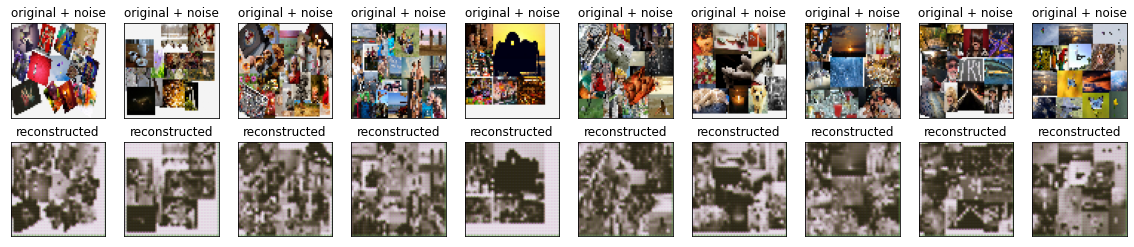

In [35]:
class Autoencoder(tf.keras.Model):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(64, 64, 3)),
            # layers.Flatten(),
            # layers.Dense(10, activation='relu'),
            layers.Conv2D(3, (1, 1), activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            layers.Conv2DTranspose(3, kernel_size=1, strides=2, activation='relu', padding='same'),
            # layers.Dense(10, activation='relu'),
            # layers.Dense(64 * 64 * 3, activation='relu'),
            # layers.Reshape((64, 64, 3))
            layers.Conv2D(3, kernel_size=(3, 3), activation='sigmoid', padding='same')
        ])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded


autoencoder = Autoencoder()
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

autoencoder.fit(X_train, X_train,
                epochs=100,
                validation_data=(X_test, X_test),
                shuffle=True)


encoded_imgs = autoencoder.encoder(X_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()


In [60]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
from keras import backend as K
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# Define the model
model = Sequential()

#1st convolution layer
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(384,384,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

#2nd convolution layer
model.add(Conv2D(2,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))
#-------------------------
#3rd convolution layer
model.add(Conv2D(2,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#4rd convolution layer
model.add(Conv2D(16,(3, 3), padding='same'))
model.add(Activation('relu'))
model.add(UpSampling2D((2, 2)))

#-------------------------

model.add(Conv2D(3,(3, 3), padding='same'))
model.add(Activation('sigmoid'))

model.summary()

# Compile the model
model.compile(optimizer='adam', loss=losses.MeanAbsoluteError())

# Generate data from the images in a folder
batch_size = 8
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
train_generator = train_datagen.flow_from_directory(
    get_root_path()/'data/raw/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='input'
    )
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
validation_generator = test_datagen.flow_from_directory(
    get_root_path()/'data/raw/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='input'
    )
    
# Train the model
model.fit(
        X_train, X_train,
        # steps_per_epoch=1000 // batch_size,
        epochs=20,
        validation_data=(X_test, X_test),
        # validation_steps=1000 // batch_size
        )
        

# # Test the model
# data_list = []
# batch_index = 0
# while batch_index <= train_generator.batch_index:
#     data = train_generator.next()
#     data_list.append(data[0])
#     batch_index = batch_index + 1
# data_list[0].shape

# predicted = model.predict(data_list[0])
# plt.imshow(data_list[0][0])
# plt.imshow(predicted[0])

Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_54 (Conv2D)          (None, 384, 384, 16)      448       
                                                                 
 activation_45 (Activation)  (None, 384, 384, 16)      0         
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 192, 192, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_55 (Conv2D)          (None, 192, 192, 2)       290       
                                                                 
 activation_46 (Activation)  (None, 192, 192, 2)       0         
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 96, 96, 2)        0         
 g2D)                                                

In [ ]:
decoded_imgs = (X_test).numpy()


n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()


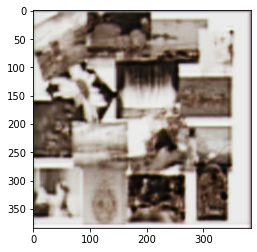

In [59]:
plt.imshow((tf.squeeze(decoded_imgs[0]) * 255).numpy().astype(int))

In [ ]:

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(X_test[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()
